# Proyecto Final
En este notebook trabajaremos con el conjunto de datos IEEE-CIS Fraud Detection, el cual proviene de una competencia en Kaggle orientada a la detección de transacciones fraudulentas en línea. El dataset incluye información transaccional, categórica y de dispositivos, lo que permite diseñar y evaluar modelos de machine learning para predecir si una transacción es fraudulenta o legítima.

El problema presenta un fuerte desbalance de clases, ya que la mayoría de transacciones no son fraudulentas, lo que representa un desafío adicional para los modelos de clasificación.

## Estrategia de Análisis

Exploración de Datos (EDA):
Se analizó la estructura del dataset, se identificaron variables poco informativas o redundantes y se realizó limpieza para optimizar el trabajo con los modelos.

### Preprocesamiento:
Se implementaron y compararon cuatro estrategias distintas para preparar los datos:

 - Sin preprocesamiento.
 - Escalado estándar con StandardScaler.
 - Reducción de dimensionalidad con PCA.
 - Escalado + PCA.

### Balanceo de Datos:
Para enfrentar el desbalance entre clases, se aplicó la técnica SMOTE (Synthetic Minority Over-sampling Technique) y se evaluó su impacto en el rendimiento de los modelos.

### Modelado:
Se entrenaron y evaluaron los siguientes algoritmos:

 - Random Forest Classifier
 - Support Vector Classifier (SVC)
 - Gradient Boosting Classifier

### Evaluación y Comparación:
Se midió el rendimiento de cada modelo bajo diferentes combinaciones de preprocesamiento y balanceo, principalmente a través de la métrica de accuracy.

## Objetivo

El objetivo principal de este trabajo es comparar el impacto del preprocesamiento y el balanceo de clases en el rendimiento de distintos modelos de clasificación, y así identificar la estrategia más adecuada para abordar el problema de detección de fraude en transacciones financieras.



El dataset fué tomado de: https://www.kaggle.com/datasets/phambacong/ieee-cis-fraud-detection


## Imports generales y funciones de ayuda.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

data_path = './train.csv'
data = pd.read_csv(data_path)

if "Unnamed: 0" in data.columns:
    transactions = data.drop(["Unnamed: 0"], axis=1)
elif "Unnamed" in data.columns:
    transactions = data.drop(["Unnamed"], axis=1)


def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.datetime64):
                continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

print("Importaciones finalizadas.")

Importaciones finalizadas.


## Exploración y optimización de los datos

Forma de las Características (Features): (590540, 435)
Forma de las Etiquetas (Labels): (590540,)

Primeras 5 filas del DataFrame:
   Unnamed: 0  TransactionID_x  isFraud  TransactionDT  TransactionAmt  \
0           0          2987000        0          86400            68.5   
1           1          2987001        0          86401            29.0   
2           2          2987002        0          86469            59.0   
3           3          2987003        0          86499            50.0   
4           4          2987004        0          86506            50.0   

   ProductCD  card1  card2  card3  card4  ...  id_31  id_32  id_33  id_34  \
0          4  13926  321.0  150.0      1  ...    123   32.0    164      3   
1          4   2755  404.0  150.0      2  ...     98   32.0     48      2   
2          4   4663  490.0  150.0      3  ...     44   24.0    132      3   
3          4  18132  567.0  150.0      2  ...     44   24.0    132      3   
4          1   4497  514.0  150.0      

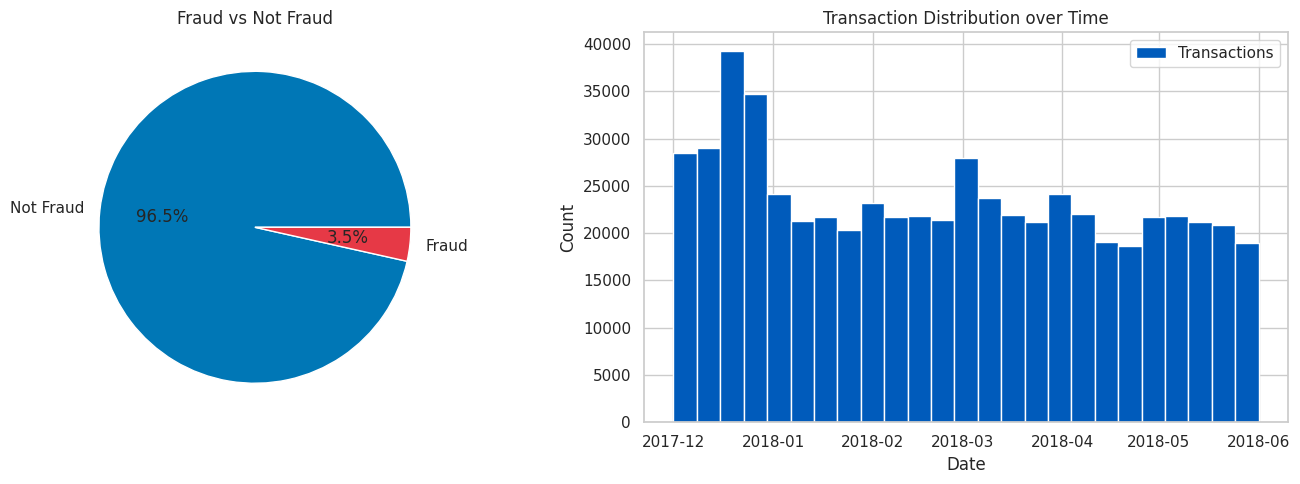


Conteo de clases: Counter({np.int8(0): 569877, np.int8(1): 20663})
Unnamed: 0         0.0
TransactionID_x    0.0
isFraud            0.0
TransactionDT      0.0
TransactionAmt     0.0
ProductCD          0.0
card1              0.0
card2              0.0
card3              0.0
card4              0.0
card5              0.0
card6              0.0
addr1              0.0
addr2              0.0
dist1              0.0
dist2              0.0
P_emaildomain      0.0
R_emaildomain      0.0
C1                 0.0
C2                 0.0
dtype: float64
Series([], dtype: float64)


In [2]:
data_reduced = reduce_mem_usage(data).copy()
del data

labels = data_reduced['isFraud'].values
features = data_reduced.drop(['isFraud'], axis=1).values


print('Forma de las Características (Features):', features.shape)
print('Forma de las Etiquetas (Labels):', labels.shape)
print('\nPrimeras 5 filas del DataFrame:')
print(data_reduced.head())

start_date = pd.to_datetime("2017-11-30")

# Convertimos TransactionDT en fecha real
data_reduced['TransactionDate'] = start_date + pd.to_timedelta(data_reduced['TransactionDT'], unit='s')

# Gráfico de clases

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].pie(
    data_reduced.isFraud.value_counts(), 
    labels=['Not Fraud', 'Fraud'], 
    autopct='%0.1f%%', 
    colors=['#0077b6', '#e63946']
)
axes[0].set_title("Fraud vs Not Fraud")

# Gráfico temporal
axes[1].hist(
    data_reduced['TransactionDate'], 
    bins=25, 
    color="#005BBB", 
    label='Transactions'
)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
axes[1].set_title('Transaction Distribution over Time')
axes[1].legend()

plt.tight_layout()
plt.show()



print("\nConteo de clases:", Counter(labels))


missing = data_reduced.isnull().mean().sort_values(ascending=False)
print(missing.head(20))


categorical_cols = data_reduced.select_dtypes(include=['object']).columns
print(data_reduced[categorical_cols].nunique().sort_values(ascending=False).head(20))


### Descubrimientos sobre los datos:
Tenemos una base muy robusta de transacciones en un rango aproximado de 6 meses, son muchas y por temas de seguridad muchas de las caracteristicas que guardan sobre cada una de las transacciones son redactadas, no tenemos una descripcion de que significan la gran mayoría de las caracteristicas de nuestro dataset, pero sin embargo podemos estar seguros que cuando llegue una nueva transacción, van a tomar estas mismas caracteristicas, por lo que de igual manera nos sirve para generar un modelo que nos ayude a dicernir si una transacción es real o es un fraudulenta. Sin embargo las conclusiones que tomemos sobre este dataset serán probablemente muy abstractas, vamos a entender las caracteristicas especificas que hacen una transaccion fraudulenta pero no vamos a saber ver estas caracteristicas en la vida cotidiana.
Cómo tenemos tantos datos, es computacionalmente 

| Grupo de variables       | Rango/Columnas                  | Descripción general                                                                 |
|---------------------------|---------------------------------|-------------------------------------------------------------------------------------|
| Identificadores           | `TransactionID`, `TransactionDT` | ID único de la transacción y timestamp relativo (segundos desde inicio del dataset). |
| Transacción básica        | `TransactionAmt`, `ProductCD`    | Monto de la transacción y tipo de producto/código de categoría.                      |
| Tarjeta                   | `card1` – `card6`                | Información de la tarjeta utilizada (tipo, emisor, categoría, enmascarado).          |
| Dirección                 | `addr1`, `addr2`                 | Información parcial de dirección/postal relacionada al usuario.                      |
| Distancias                | `dist1`, `dist2`                 | Distancias geográficas aproximadas entre direcciones (billing/shipping).             |
| Variables de cuenta       | `P_emaildomain`, `R_emaildomain` | Dominios de correo del pagador y receptor.                                           |
| Identidad                 | `id_01` – `id_38`                | Características de dispositivo, navegador, dirección IP, etc. (anonimizadas).        |
| Conteos                   | `C1` – `C14`                     | Features de tipo “count”, agregados estadísticos de comportamiento (anonimizados).   |
| Diferencias temporales    | `D1` – `D15`                     | Diferencias de tiempo (ej. días desde transacciones anteriores, anonimizados).       |
| Flags de coincidencia     | `M1` – `M9`                      | Variables binarias/categóricas que indican si ciertos datos coinciden (billing/shipping, email, etc.). |
| Features derivados (Vesta)| `V1` – `V339`                    | Conjunto masivo de variables creadas por Vesta: métricas de riesgo, patrones, ratios, etc. (anonimizados). |
| Etiqueta                  | `isFraud`                        | Variable objetivo: 1 si la transacción es fraudulenta, 0 si es legítima.             |



In [3]:
zero_threshold = 0.7
zero_pct = np.mean(features == 0, axis=0)

cols_to_drop_zeros = np.where(zero_pct > zero_threshold)[0].tolist()
features_filtered = np.delete(features, cols_to_drop_zeros, axis=1)

print(f"Columnas con > {zero_threshold*100}% de ceros: {len(cols_to_drop_zeros)}")

print('Forma de las Características despues del drop 1:', features_filtered.shape)

low_variance_cols = []
for i in range(features_filtered.shape[1]):
    col = features_filtered[:, i]
    if len(np.unique(col)) == 1:
        low_variance_cols.append(i)
    elif np.std(col) / (np.mean(col) + 1e-10) < 0.01:
        low_variance_cols.append(i)

features_filtered2 = np.delete(features_filtered, low_variance_cols, axis=1)

print(f"Columnas con baja varianza: {len(low_variance_cols)}")
print('Forma de las Características despues del drop 2:', features_filtered2.shape)

corr_matrix = np.corrcoef(features_filtered, rowvar=False)
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

high_corr_cols = []
for j in range(corr_matrix.shape[1]):
    if any(corr_matrix[i, j] > 0.95 for i in range(j)):
        high_corr_cols.append(j)


features_filtered2 = np.delete(features_filtered2, high_corr_cols, axis=1)
print(f"Columnas altamente correlacionadas: {len(high_corr_cols)}")
print('Forma de las Características despues del drop 3:', features_filtered2.shape)


Columnas con > 70.0% de ceros: 226
Forma de las Características despues del drop 1: (590540, 209)
Columnas con baja varianza: 7
Forma de las Características despues del drop 2: (590540, 202)
Columnas altamente correlacionadas: 31
Forma de las Características despues del drop 3: (590540, 171)


In [4]:
X_temp, X_unused, y_temp, y_unused = train_test_split(
    features_filtered2,
    labels,
    test_size=0.97,   # dejamos fuera el 65% para quedarnos con el 35%
    random_state=42,
    stratify=labels
)

# Ahora separamos dentro de ese 35% el 30% y 5%
X_train, X_test, y_train, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,   # 5 de 35 ≈ 14.3% de ese subset
    random_state=42,
    stratify=y_temp
)

print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Distribución en y_train:', Counter(y_train))
print('Distribución en y_test:', Counter(y_test))

Forma de X_train: (14172, 171)
Forma de X_test: (3544, 171)
Distribución en y_train: Counter({np.int8(0): 13676, np.int8(1): 496})
Distribución en y_test: Counter({np.int8(0): 3420, np.int8(1): 124})


In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline

# --- PARÁMETROS PARA GridSearchCV ---
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
}
param_grid_svc = {
    'model__C': [1, 10],
    'model__kernel': ['rbf']
}
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
}

# --- DICCIONARIO DE MODELOS ---
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'SVC': (SVC(random_state=42, probability=True), param_grid_svc),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb)
}

# --- DICCIONARIO PARA ALMACENAR RESULTADOS ---
results = {}

# --- BUCLE PRINCIPAL DE EXPERIMENTACIÓN  ---
preproc_steps = {
    "Original": [],
    "Scaler": [('scaler', StandardScaler())],
    "PCA": [('pca', PCA(n_components=0.95))],
    "Scaler_PCA": [('scaler', StandardScaler()), ('pca', PCA(n_components=0.95))]
}

for preproc_name, preproc_list in preproc_steps.items():
    print(f"================== ESTRATEGIA: {preproc_name} ==================")

    # Aplicar preprocesamiento solo al conjunto de test una vez
    X_train_proc, X_test_proc = X_train, X_test
    if preproc_list:
        preproc_pipeline = ImbPipeline(steps=preproc_list)
        X_train_proc = preproc_pipeline.fit_transform(X_train)
        X_test_proc = preproc_pipeline.transform(X_test)

    for model_name, (model, params) in models.items():
        # --- Escenario SIN Balanceo ---
        print(f"\n--- Entrenando {model_name} (Sin Balanceo) ---")
        pipeline_no_balance = ImbPipeline(steps=preproc_list + [('model', model)])

        # Ajustamos los nombres de los parámetros para que coincidan con el pipeline
        search_params_no_balance = {k: v for k, v in params.items()}

        grid_search = GridSearchCV(pipeline_no_balance, search_params_no_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)


        accuracy = accuracy_score(y_test, y_pred)
        key = f"{preproc_name} + Sin Balanceo + {model_name}"
        results[key] = accuracy
        print(f"Accuracy en Test: {accuracy:.4f}")

        # --- Escenario CON Balanceo (SMOTE) ---
        print(f"--- Entrenando {model_name} (Con SMOTE) ---")

        # Creamos el pipeline que incluye SMOTE
        pipeline_with_balance = ImbPipeline(steps=[
            *preproc_list,
            ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
            ('model', model)
        ])

        search_params_balance = {k: v for k, v in params.items()}

        grid_search_smote = GridSearchCV(pipeline_with_balance, search_params_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search_smote.fit(X_train, y_train)
        best_model_smote = grid_search_smote.best_estimator_
        y_pred_smote = best_model_smote.predict(X_test)

        accuracy_smote = accuracy_score(y_test, y_pred_smote)
        key_smote = f"{preproc_name} + Con SMOTE + {model_name}"
        results[key_smote] = accuracy_smote
        print(f"Accuracy en Test: {accuracy_smote:.4f}")

================== ESTRATEGIA: Original ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9718
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9726

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9650
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9650

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9709
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9732
================== ESTRATEGIA: Scaler ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9718
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9718

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9659
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9532

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9709
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9709
================== ESTRATEGIA: PCA =========

In [6]:
def create_ann_model(input_shape):
    """Crea y compila un modelo de red neuronal secuencial."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- BUCLE DE EXPERIMENTACIÓN PARA LA ANN ---
for preproc_name, preproc_list in preproc_steps.items():
    print(f"================== ANN CON ESTRATEGIA: {preproc_name} ==================")

    # Aplicar preprocesamiento
    X_train_proc, X_test_proc = X_train, X_test
    if preproc_list:
        preproc_pipeline = ImbPipeline(steps=preproc_list)
        X_train_proc = preproc_pipeline.fit_transform(X_train)
        X_test_proc = preproc_pipeline.transform(X_test)

    # --- Escenario ANN Sin Balanceo ---
    print(f"\n---------- ANN Sin Balanceo ----------")
    input_dim = X_train_proc.shape[1]
    ann_model = create_ann_model(input_dim)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    ann_model.fit(X_train_proc, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    loss, accuracy = ann_model.evaluate(X_test_proc, y_test, verbose=0)
    key = f"{preproc_name} + Sin Balanceo + ANN"
    results[key] = accuracy
    print(f"Accuracy en Test: {accuracy:.4f}")

    # --- Escenario ANN Con SMOTE (Metodología Correcta) ---
    print(f"\n---------- ANN Con SMOTE ----------")

    # 1. Dividir los datos de entrenamiento procesados en sub-entrenamiento y validación
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_proc, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # 2. Aplicar SMOTE SOLO al subconjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sub, y_train_sub)

    # 3. Entrenar con datos rebalanceados, validar con datos originales
    input_dim_smote = X_train_resampled.shape[1]
    ann_model_smote = create_ann_model(input_dim_smote)

    ann_model_smote.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=64,
                        validation_data=(X_val, y_val), # Usar el set de validación limpio
                        callbacks=[early_stopping], verbose=0)

    loss_smote, accuracy_smote = ann_model_smote.evaluate(X_test_proc, y_test, verbose=0)
    key_smote = f"{preproc_name} + Con SMOTE + ANN"
    results[key_smote] = accuracy_smote
    print(f"Accuracy en Test: {accuracy_smote:.4f}")

================== ANN CON ESTRATEGIA: Original ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-03 17:00:27.657829: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Accuracy en Test: 0.9650

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.0350
================== ANN CON ESTRATEGIA: Scaler ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9712

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.8426
================== ANN CON ESTRATEGIA: PCA ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9650

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.8186
================== ANN CON ESTRATEGIA: Scaler_PCA ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9715

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.7954


--- Tabla Comparativa de Resultados (Ordenados por Accuracy) ---
                                      Combinacion  Accuracy
0        Original + Con SMOTE + Gradient Boosting  0.973194
1            Original + Con SMOTE + Random Forest  0.972630
2           Scaler + Sin Balanceo + Random Forest  0.971783
3         Original + Sin Balanceo + Random Forest  0.971783
4              Scaler + Con SMOTE + Random Forest  0.971783
5                 Scaler_PCA + Sin Balanceo + ANN  0.971501
6   Scaler_PCA + Sin Balanceo + Gradient Boosting  0.971219
7                     Scaler + Sin Balanceo + ANN  0.971219
8       Scaler + Sin Balanceo + Gradient Boosting  0.970937
9     Original + Sin Balanceo + Gradient Boosting  0.970937
10         Scaler + Con SMOTE + Gradient Boosting  0.970937
11      Scaler_PCA + Sin Balanceo + Random Forest  0.969808
12         Scaler_PCA + Con SMOTE + Random Forest  0.966986
13                    Scaler + Sin Balanceo + SVC  0.965858
14                       PCA + Sin 

/tmp/ipykernel_7212/2190554719.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Combinacion', data=results_df, palette='viridis')


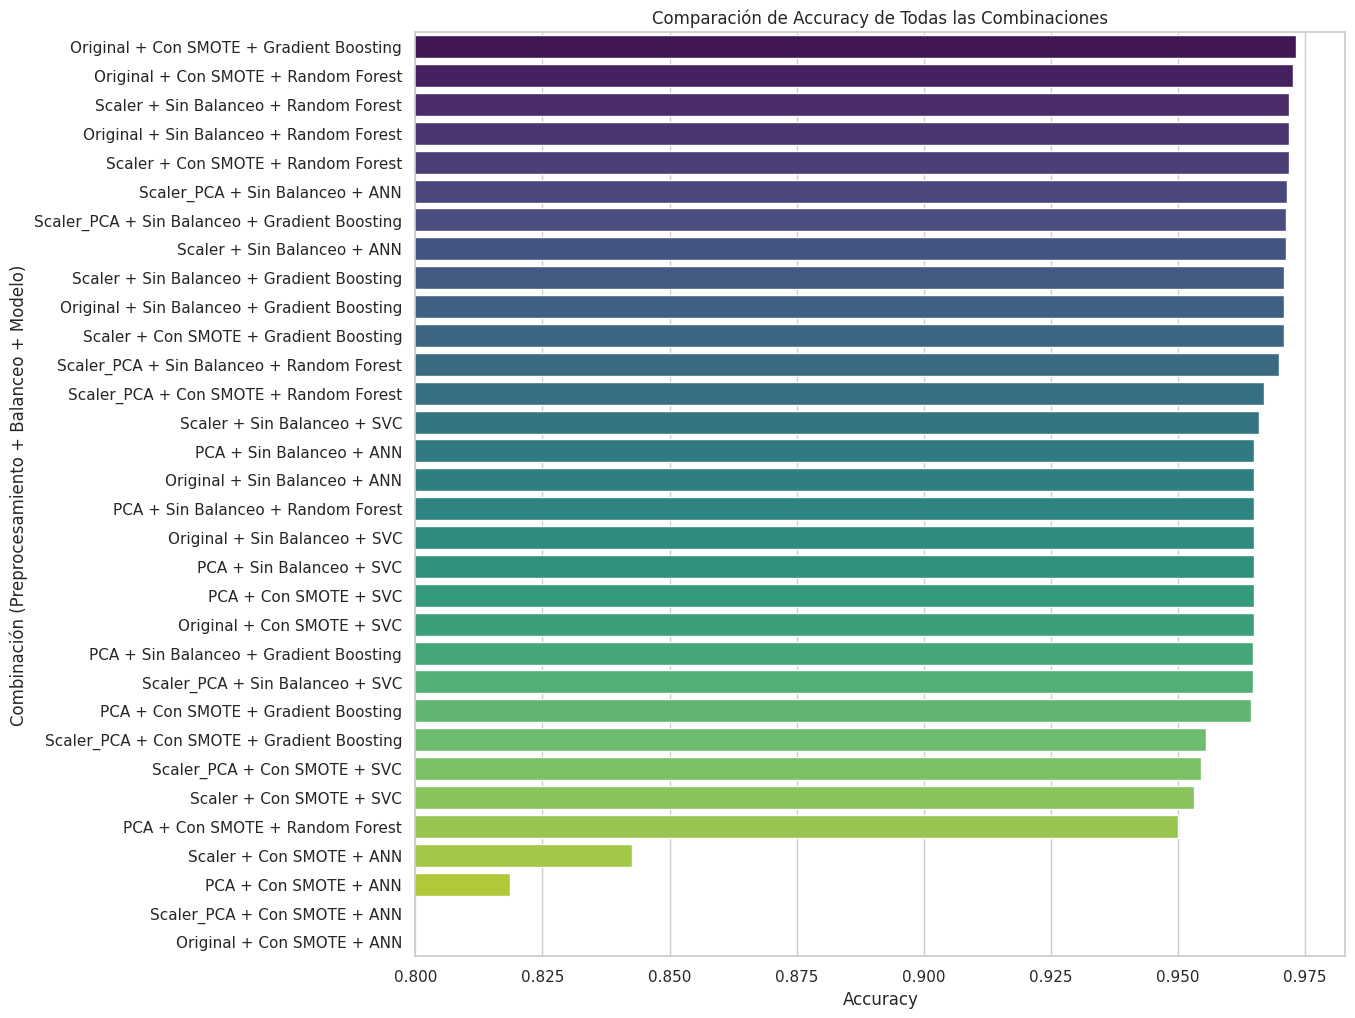


--- Conclusión ---
La mejor combinación fue:
Original + Con SMOTE + Gradient Boosting
Alcanzando un accuracy de: 0.9732


In [7]:
# Convertir el diccionario de resultados a un DataFrame para una mejor visualización
results_df = pd.DataFrame(list(results.items()), columns=['Combinacion', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("--- Tabla Comparativa de Resultados (Ordenados por Accuracy) ---")
print(results_df)

# Visualizar los resultados para una comparación más clara
plt.figure(figsize=(12, 12))
sns.barplot(x='Accuracy', y='Combinacion', data=results_df, palette='viridis')
plt.title('Comparación de Accuracy de Todas las Combinaciones')
plt.xlabel('Accuracy')
plt.ylabel('Combinación (Preprocesamiento + Balanceo + Modelo)')
plt.xlim(0.8, max(results_df['Accuracy']) * 1.01) # Ajustar el límite para ver mejor las diferencias
plt.show()

print("\n--- Conclusión ---")
if not results_df.empty:
    print(f"La mejor combinación fue:\n{results_df.iloc[0]['Combinacion']}")
    print(f"Alcanzando un accuracy de: {results_df.iloc[0]['Accuracy']:.4f}")
else:
    print("No se generaron resultados para mostrar.")

In [14]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


# 2. Entrenar un modelo de Regresión Logística
# Se crea una instancia del modelo y se entrena con los datos
model = LogisticRegression(max_iter=1000000)
model.fit(X_train, y_train)
print("✅ Modelo entrenado.")

# (Opcional) Evaluar el modelo recién entrenado para ver su rendimiento
predictions_before_saving = model.predict(X_test)
accuracy_before = accuracy_score(y_test, predictions_before_saving)
print(f"   - Precisión (antes de guardar): {accuracy_before:.4f}")


####################################### acá se guarda el modelo
# 3. Guardar el modelo entrenado en un archivo
# El objeto 'model' que contiene todo el aprendizaje se guarda en un archivo.
model_filename = 'modelo.pkl'
joblib.dump(model, model_filename)
print(f"✅ Modelo guardado exitosamente como '{model_filename}'")



✅ Modelo entrenado.
   - Precisión (antes de guardar): 0.9642
✅ Modelo guardado exitosamente como 'modelo.pkl'


/home/pier/mi_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 12529 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
